# pop_bilateral filter with just in time compilation and nogil
Benchmark of scikit-image's pop_bilateral filter (rank cython) vs python jit with numba. 

Numba also allows for easy multiprocessing with releasing the global intepreter lock.

In [1]:
%matplotlib inline
from numba import jit
import numpy as np
from skimage.io import imread, imshow
from skimage.filters.rank import pop_bilateral
from skimage.morphology import square

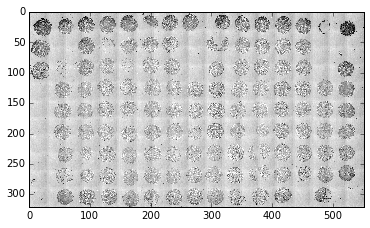

In [2]:
img = imread('stitched.png')
imshow(img[::16, ::16])

In [3]:
%time pop_sk = pop_bilateral(img, square(9))

CPU times: user 23.2 s, sys: 452 ms, total: 23.7 s
Wall time: 24.2 s


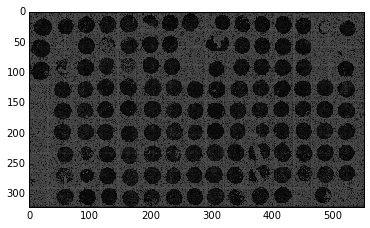

In [4]:
imshow(pop_sk[::16, ::16])

In [5]:
@jit(nogil=True)
def pop_bilateral_numba(img, selem, s0=10, s1=10):
    img = img.astype(np.int16) # avoid overrun when calc diff
    out = np.zeros(img.shape, dtype=np.uint8) # assume to get values << 255
    iy, ix = img.shape
    sy, sx = selem.shape
    sy = sy//2
    sx = sx//2
    img = np.pad(img, sy, mode='edge') # pad
    for i in range(sy, iy+sy): # shift limits
        for j in range(sx, ix+sx):
            val = img[i, j]
            o = 0
            for n in range(-sy, sy+1):
                for m in range(-sx, sx+1):
                    diff = img[(i+n), (j+m)] - val
                    if diff >= -s0 and diff <= s1:
                        o += 1
            out[i, j] = o # cheaper than accessing array in each inner loop
    return out

In [6]:
%time pop_nb = pop_bilateral_numba(img, square(9))

CPU times: user 15.2 s, sys: 712 ms, total: 15.9 s
Wall time: 16.8 s


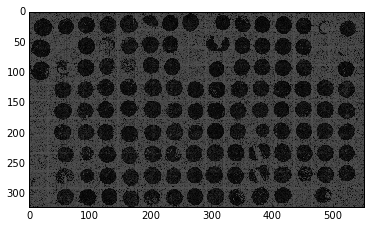

In [7]:
imshow(pop_nb[::16, ::16].astype(np.uint8))

In [8]:
from math import ceil
from multiprocessing import cpu_count
import dask.array as da

def _get_chunks(shape, ncpu):
    """
    Split the array into equal sized chunks based on the number of
    available processors. The last chunk in each dimension absorbs the
    remainder array elements if the number of cpus does not divide evenly into
    the number of array elements.
    >>> _get_chunks((4, 4), 4)
    ((2, 2), (2, 2))
    >>> _get_chunks((4, 4), 2)
    ((2, 2), (4,))
    >>> _get_chunks((5, 5), 2)
    ((2, 3), (5,))
    >>> _get_chunks((2, 4), 2)
    ((1, 1), (4,))
    """
    chunks = []
    nchunks_per_dim = int(ceil(ncpu ** (1./len(shape))))

    used_chunks = 1
    for i in shape:
        if used_chunks < ncpu:
            regular_chunk = i // nchunks_per_dim
            remainder_chunk = regular_chunk + (i % nchunks_per_dim)

            if regular_chunk == 0:
                chunk_lens = (remainder_chunk,)
            else:
                chunk_lens = ((regular_chunk,) * (nchunks_per_dim - 1) +
                              (remainder_chunk,))
        else:
            chunk_lens = (i,)

        chunks.append(chunk_lens)
        used_chunks *= nchunks_per_dim
    return tuple(chunks)


def apply_chunks(function, array, chunks=None, depth=0, mode=None,
                 extra_arguments=(), extra_keywords={}):
    """Map a function in parallel across an array.
    Split an array into possibly overlapping chunks of a given depth and
    boundary type, call the given function in parallel on the chunks, combine
    the chunks and return the resulting array.
    Parameters
    ----------
    function : function
        Function to be mapped which takes an array as an argument.
    array : numpy array
        Array which the function will be applied to.
    chunks : int, tuple, or tuple of tuples, optional
        A single integer is interpreted as the length of one side of a square
        chunk that should be tiled across the array.  One tuple of length
        ``array.ndim`` represents the shape of a chunk, and it is tiled across
        the array.  A list of tuples of length ``ndim``, where each sub-tuple
        is a sequence of chunk sizes along the corresponding dimension. If
        None, the array is broken up into chunks based on the number of
        available cpus. More information about chunks is in the documentation
        `here <https://dask.pydata.org/en/latest/array-design.html>`_.
    depth : int, optional
        Integer equal to the depth of the added boundary cells. Defaults to
        zero.
    mode : 'reflect', 'periodic', 'wrap', 'nearest', optional
        type of external boundary padding
    extra_arguments : tuple, optional
        Tuple of arguments to be passed to the function.
    extra_keywords : dictionary, optional
        Dictionary of keyword arguments to be passed to the function.
    """
    if chunks is None:
        shape = array.shape
        ncpu = cpu_count()
        chunks = _get_chunks(shape, ncpu)

    if mode == 'wrap':
        mode = 'periodic'

    def wrapped_func(arr):
        return function(arr, *extra_arguments, **extra_keywords)

    darr = da.from_array(array, chunks=chunks)
    return darr.map_overlap(wrapped_func, depth, boundary=mode).compute()

In [9]:
%time pop_da = apply_chunks(pop_bilateral_numba, img, extra_arguments=(square(9),))

CPU times: user 22.8 s, sys: 1.04 s, total: 23.8 s
Wall time: 8.66 s


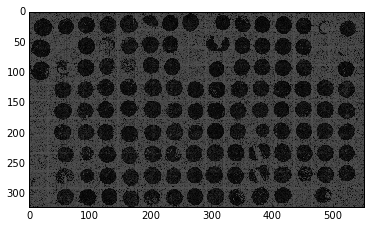

In [10]:
imshow(pop_da[::16, ::16])